# Title
 

### Imports

In [75]:
import requests, time, csv
from bs4 import BeautifulSoup

import pandas as pd
import re

import itertools

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
from collections import Counter

%matplotlib inline

plt.style.use('default')
sns.set_palette("husl")

### Scraper

In [ ]:
BATCH = 100         # docs per "page"
START = 1          # first record index (1-based on DARE)

count, start = 0, START
with open("uva_dare_v2.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["year","authors"])

    while True:
        url = (
            "https://dare.uva.nl/search"
            f"?sort=year;browse-all=yes;docsPerPage={BATCH};startDoc={start}"
        )
        r = requests.get(url, headers={"User-Agent":"uva-scraper-demo/1.0"}, timeout=30)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")

        items = soup.select("div.doctitle")
        if not items:
            print("No more results — stopping.")
            break

        for dt in items:
            text = dt.get_text(" ", strip=True)
            # authors before '(', year inside '(...)'
            if "(" in text and ")" in text:
                authors = text.split("(", 1)[0].strip()
                year = text.split("(", 1)[1].split(")", 1)[0].strip()
            else:
                authors, year = "", ""

            w.writerow([year, authors])
            count += 1

        print(f"Fetched {len(items)} at startDoc={start} — total {count}")
        start += BATCH
        time.sleep(1.2)

print(f"Done. Collected {count} records.")


Fetched 100 at startDoc=1 — total 100
Fetched 100 at startDoc=101 — total 200
Fetched 100 at startDoc=101 — total 200
Fetched 100 at startDoc=201 — total 300
Fetched 100 at startDoc=201 — total 300
Fetched 100 at startDoc=301 — total 400
Fetched 100 at startDoc=301 — total 400
Fetched 100 at startDoc=401 — total 500
Fetched 100 at startDoc=401 — total 500


KeyboardInterrupt: 

### Cleaning

In [228]:
def standardise_data(df):
    """
    Standardise year format and clean author names
    """
    df_clean = df.copy()
    
    # clean year column 
    ## extract just the year part from dates like "1-10-2025"
    def extract_year(year_str):
        year_str = str(year_str)
        year_match = re.search(r'(\d{4})', year_str)
        if year_match:
            return year_match.group(1)
        
        return year_str
    
    df_clean['year'] = df_clean['year'].apply(extract_year)

    ## drop rows with invalid years 
    df_clean = df_clean[df_clean['year'].apply(lambda x: bool(re.match(r'^\d{4}$', str(x))))]
    
    # clean author names
    ## remove extra whitespace
    df_clean['authors'] = df_clean['authors'].apply(
        lambda x: re.sub(r'\s+', ' ', str(x).strip()) if pd.notna(x) else x
    )
    
    return df_clean


def remove_near_duplicates(df):
    """
    Remove near-duplicates that have same authors but might have different year formats
    """
    df_clean = df.copy()
    
    df_clean['authors_clean'] = df_clean['authors'].apply(
        lambda x: re.sub(r'[^a-zA-Z]', '', str(x).lower()) if pd.notna(x) else ''
    )
    
    # find duplicates based on cleaned authors (ignoring year differences)
    author_duplicates = df_clean[df_clean.duplicated(['authors_clean'], keep=False)]
    
    if len(author_duplicates) > 0:
        
        author_groups = author_duplicates.groupby('authors_clean')
        
        removed_count = 0
        indices_to_remove = []
        
        for authors_clean, group in author_groups:
            if len(group) > 1:                
                keep_index = group.index[0]
                remove_indices = group.index[1:]
                indices_to_remove.extend(remove_indices)
                removed_count += len(remove_indices)
        
        if indices_to_remove:
            df_clean = df_clean.drop(indices_to_remove)
    
    df_clean = df_clean.drop('authors_clean', axis=1)
    
    return df_clean



In [229]:
def format_authors(authors_string):
    """
    Reformats author names to SurnameN format where N is the first letter(s) of the first name.
    Also removes white spaces.
    """

    # removes anything before the last author separator
    authors_string = authors_string.replace(' & ', ', ')
    authors_string = authors_string.replace(' ...', ', ')
    parts = [part.strip() for part in authors_string.split(',')]
    
    formatted_authors = []
    i = 0
    
    while i < len(parts):
        part = parts[i]
        
        # skips empty parts
        if not part:
            i += 1
            continue
            
        # check if this part looks like a surname 
        ## no dots, or contains prefixes
        has_prefix = any(prefix in part.lower() for prefix in ['van', 'de', 'der'])
        has_dot = '.' in part
        
        if not has_dot or has_prefix:
            # this is probably a surname
            surname = part
            
            # looks for first name next to it
            initials = ""
            j = i + 1
            while j < len(parts) and ('.' in parts[j] or '-' in parts[j]):
                # extracts everything from first name part
                first_name_part = parts[j]
                for char in first_name_part:
                    if char.isupper() or char in '-.':
                        initials += char
                j += 1
            
            # cleaning and formatting
            initials = initials.replace('.', '').replace(' ', '')
            initials = initials.replace('-', '')
            
            formatted_author = surname.replace(' ', '') + initials
            formatted_authors.append(formatted_author)
            
            i = j  # skips what we've done
        else:
            # for organisations
            initials = ""
            for char in part:
                if char.isupper() or char in '-.':
                    initials += char
            initials = initials.replace('.', '').replace(' ', '').replace('-', '')
            
            if initials:
                formatted_authors.append(initials)
            i += 1
    
    return ', '.join(formatted_authors)



In [230]:
def clean(input_file, output_file):
    """
    Clean the CSV file by removing duplicate entries and standardising the data
    """
    df = pd.read_csv(input_file)
    print(f"Initial dataset: {len(df)} rows")
        
    duplicates = df[df.duplicated(keep=False)]
    
    # remove exact duplicates (same year and same authors)
    df_clean = df.drop_duplicates()
    
    # standardise year format and author names
    df_clean = standardise_data(df_clean)
    
    # remove near-duplicates
    df_clean = remove_near_duplicates(df_clean)

    # drop na rows
    df_clean = df_clean.dropna(subset=['year', 'authors'])

    # drop that one 297 year i cant seem to get rid of 
    df_clean = df_clean[df_clean['year'] != '0297']

    # format authors
    df_clean['authors'] = df_clean['authors'].apply(format_authors)

    # save
    df_clean.to_csv(output_file, index=False)
    print(f"\nCleaned data saved to: {output_file}")
    print(f"Final dataset: {len(df_clean)} rows")
    
    
    return df_clean



In [266]:
def min_degree_filter_clean(min_degree, input_file, output_file):
    """
    Remove rows that have only one author
    """

    df = pd.read_csv(input_file)
    
    df['author_count'] = df['authors'].apply(
        lambda x: len(str(x).split(','))
    )
    
    df = df[df['author_count'] > min_degree]
    
    df = df.drop('author_count', axis=1)

    df.to_csv(output_file, index=False)
    print(f"\nCleaned filtered data saved to: {output_file}, min degree of {min_degree}")
    print(f"Final dataset: {len(df)} rows")
    
    df.to_csv(output_file, index=False)
    return df






In [268]:
input_file = "uva_dare.csv"
output_file = "uva_dare_cleaned.csv"
output_file_min_degree = "uva_dare_cleaned_5.csv"
    
cleaned_df = clean(input_file, output_file)
df = min_degree_filter_clean(5, output_file, output_file_min_degree)

Initial dataset: 210079 rows

Cleaned data saved to: uva_dare_cleaned.csv
Final dataset: 110983 rows

Cleaned filtered data saved to: uva_dare_cleaned_5.csv, min degree of 5
Final dataset: 23632 rows


### Convert to gephi

In [269]:
# author list
authors_set = set()
for authors in df['authors']:
    author_list = [author.strip() for author in authors.split(',')]
    authors_set.update(author_list)

# nodes
nodes_df = pd.DataFrame(list(authors_set), columns=['Id'])
nodes_df['Label'] = nodes_df['Id']

# pairwise edges
edges = []
for _, row in df.iterrows():
    if pd.notna(row['authors']):
        authors = [author.strip() for author in row['authors'].split(',')]
        year = row['year']
        
        for author1, author2 in itertools.combinations(authors, 2):
            u, v = (author1, author2) if author1 < author2 else (author2, author1)
            edges.append({
                'Source': u,
                'Target': v,
                'Year': year,
                'Weight': 1,  
                'Type': 'Undirected'
            })
            

edges_df = pd.DataFrame(edges)

# Aggregate repeated collaborations
agg = (edges_df
       .groupby(["Source","Target"], as_index=False)
       .agg(Weight=("Year","count"),
            FirstYear=("Year","min"),
            LastYear=("Year","max")))

nodes_df.to_csv('nodes_5.csv', index=False)
edges_df.to_csv('edges_5.csv', index=False)


### Assignment 1

In [ ]:
# Build G
G = nx.Graph()
G.add_weighted_edges_from((r.Source, r.Target, int(r.Weight)) for r in agg.itertuples(index=False))

# Largest connected component for path-based metrics
if G.number_of_nodes() > 0:
    lcc_nodes = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(lcc_nodes).copy()
else:
    Gcc = G


print(f"Created NetworkX graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Created NetworkX graph with 88512 nodes and 770854 edges


### Network summary


In [271]:
def network_summary(G, df):
    """
    Print a summary of the network properties.
    
    Args:
        G (networkx.Graph): Network graph
        df (pandas.DataFrame): Original data
    """
    print(f"\n{'='*60}")
    print("NETWORK SUMMARY")
    print(f"{'='*60}")
    
    print(f"Number of authors (nodes): {G.number_of_nodes()}")
    print(f"Number of pairwise connections (edges): {G.number_of_edges()}")
    print(f"Number of co-author pairs in dataset: {len(df)}")
    
    # Connected components
    num_components = nx.number_connected_components(G)
    largest_cc_size = len(max(nx.connected_components(G), key=len))
    
    print(f"Number of connected components: {num_components}")
    print(f"Size of largest connected component: {largest_cc_size}")
    print(f"Percentage in largest component: {largest_cc_size/G.number_of_nodes()*100:.1f}%")
    
    # Density
    density = nx.density(G)
    print(f"Network density: {density:.6f}")
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

In [272]:
network_summary(G, edges_df)


NETWORK SUMMARY
Number of authors (nodes): 88512
Number of pairwise connections (edges): 770854
Number of co-author pairs in dataset: 1099367
Number of connected components: 231
Size of largest connected component: 86591
Percentage in largest component: 97.8%
Network density: 0.000197
Average clustering coefficient: 0.8556


### Degree distribution

In [243]:
def plot_degree_distribution(G):
    """
    Plot the degree distribution of the network for authors with at least 1 co-author.
    
    Args:
        G (networkx.Graph): Network graph
    """
    print("Plotting degree distribution...")
    
    # Get degree sequence
    degrees = [G.degree(n) for n in G.nodes() if G.degree(n) >= 1]
    degree_counts = Counter(degrees)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear scale plot
    degrees_list = list(degree_counts.keys())
    counts_list = list(degree_counts.values())
    
    ax1.bar(degrees_list, counts_list, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Degree (≥ 1)')
    ax1.set_ylabel('Number of Authors')
    ax1.set_title('Degree Distribution (Linear Scale)')
    ax1.grid(True, alpha=0.3)
    
    # Log-log scale plot
    ax2.loglog(degrees_list, counts_list, 'bo', alpha=0.7, markersize=4)
    ax2.set_xlabel('Degree (≥ 1, log scale)')
    ax2.set_ylabel('Number of Authors (log scale)')
    ax2.set_title('Degree Distribution (Log-Log Scale)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('degree_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print basic statistics
    print(f"\nDegree Distribution Statistics:")
    print(f"Number of authors with co-authors: {len(degrees)}")
    print(f"Mean degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")
    print(f"Standard deviation: {np.std(degrees):.2f}")


Plotting degree distribution...


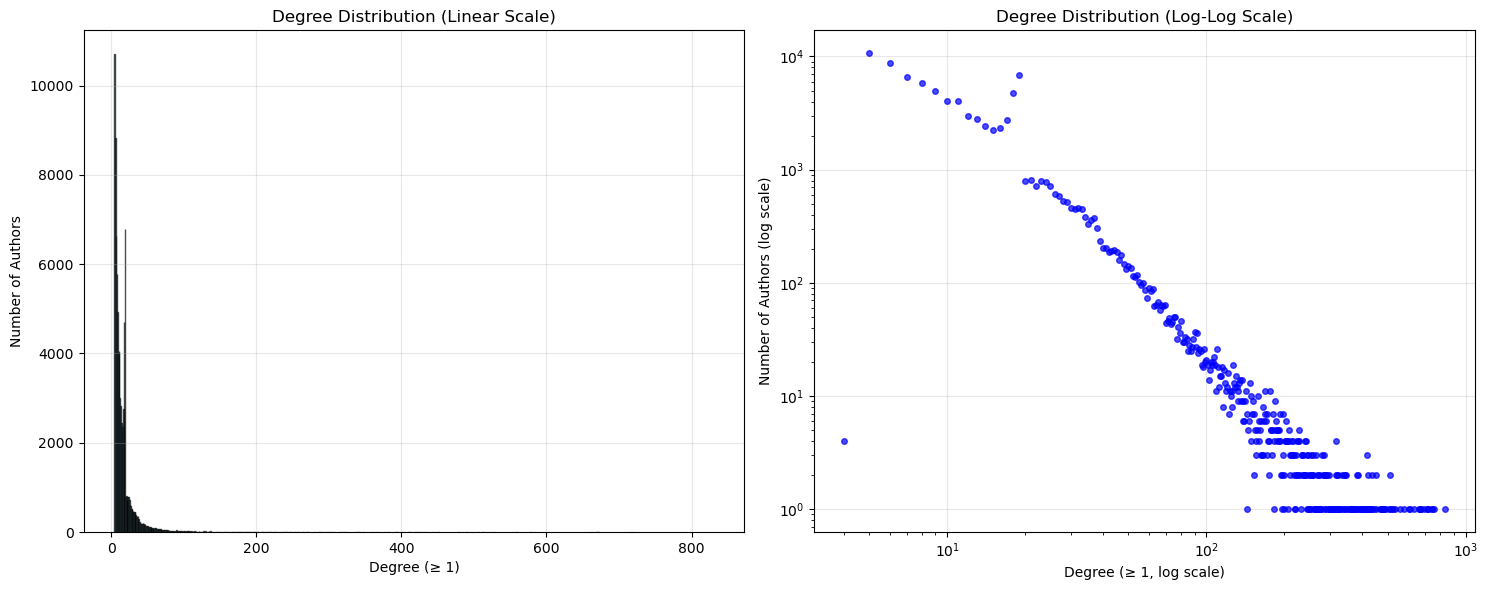


Degree Distribution Statistics:
Number of authors with co-authors: 88512
Mean degree: 17.42
Median degree: 11.00
Max degree: 831
Min degree: 4
Standard deviation: 25.78


In [244]:
plot_degree_distribution(G)

### Centrality Analysis

In [ ]:

# === Step 7. Sampling for large networks ===
def create_sampled_network(G, target_size=5000):
    """Create a sampled network for feasible computation."""
    if G.number_of_nodes() <= target_size:
        return G
    
    print(f"Network too large ({G.number_of_nodes()} nodes), sampling to {target_size} nodes...")
    
    # Get top degree nodes and some random nodes
    degrees = dict(G.degree())
    top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:target_size//2]
    
    # Add random nodes
    remaining_nodes = list(set(G.nodes()) - set(top_nodes))
    random_nodes = random.sample(remaining_nodes, target_size - len(top_nodes))
    
    sampled_nodes = set(top_nodes) | set(random_nodes)
    G_sampled = G.subgraph(sampled_nodes).copy()
    
    print(f"Sampled network: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")
    return G_sampled

# Apply sampling for networks larger than 10,000 nodes
if G.number_of_nodes() > 10000:
    G = create_sampled_network(G, target_size=5000)


def calculate_centrality_measures(G):
    """
    Calculate various centrality measures for the network.
    
    Args:
        G (networkx.Graph): Network graph
        
    Returns:
        dict: Dictionary containing centrality measures
    """
    print("Calculating centrality measures...")
    centralities = {}
    n_nodes = G.number_of_nodes()

    # Degree centrality
    print("  - Degree centrality...")
    centralities['degree'] = nx.degree_centrality(G)

    # Betweenness centrality (with sampling for large networks)
    print("  - Betweenness centrality...")
    if n_nodes > 1000:
        k = min(1000, n_nodes)  # Define k here
        centralities['betweenness'] = nx.betweenness_centrality(G, k=k, seed=42)
        print(f"    (using sampling with k={k} nodes)")
    else:
        centralities['betweenness'] = nx.betweenness_centrality(G)

    # Closeness centrality (with approximation for large networks)
    print("  - Closeness centrality...")
    if n_nodes > 2000:
        # Use approximate closeness
        centralities['closeness'] = approximate_closeness(G)
        print("    (using approximate closeness)")
    else:
        # Use exact closeness on largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc)
        closeness_largest = nx.closeness_centrality(G_largest)
        centralities['closeness'] = {node: closeness_largest.get(node, 0) for node in G.nodes()}

    # Eigenvector centrality with fallback
    print("  - Eigenvector centrality...")
    try:
        largest_cc = max(nx.connected_components(G), key=len)
        if len(largest_cc) <= 3000:  # Only try for reasonably sized components
            G_largest = G.subgraph(largest_cc)
            ev = nx.eigenvector_centrality(G_largest, max_iter=500, tol=1e-4)
            centralities['eigenvector'] = {node: ev.get(node, 0) for node in G.nodes()}
        else:
            raise nx.NetworkXError("Largest component too large for eigenvector")
    except (nx.NetworkXError, nx.PowerIterationFailedConvergence) as e:
        print(f"    Using PageRank instead: {e}")
        centralities['eigenvector'] = nx.pagerank(G)

    # Add PageRank as well
    print("  - PageRank...")
    centralities['pagerank'] = nx.pagerank(G, max_iter=200)

    return centralities

def approximate_closeness(G, sample_size=1000):
    """Approximate closeness centrality using sampling."""
    nodes = list(G.nodes())
    if len(nodes) > sample_size:
        sample_nodes = random.sample(nodes, sample_size)
    else:
        sample_nodes = nodes
    
    closeness = {}
    for node in G.nodes():
        total_distance = 0
        reachable_count = 0
        
        for target in sample_nodes:
            if node == target:
                continue
            try:
                dist = nx.shortest_path_length(G, source=node, target=target)
                total_distance += dist
                reachable_count += 1
            except nx.NetworkXNoPath:
                pass
        
        if reachable_count > 0 and total_distance > 0:
            closeness[node] = reachable_count / total_distance
        else:
            closeness[node] = 0
    
    return closeness





In [171]:
# centralities = calculate_centrality_measures(G)



# Convert dict of dicts → DataFrame
centrality_df = pd.DataFrame(centralities)
centrality_df.index.name = 'Node'
centrality_df.reset_index(inplace=True)

centrality_df.to_csv('centrality_measures_5.csv', index=False)

print("Centrality measures saved to 'centrality_measures.csv'.")

# === Step 10. Print top nodes ===
print("\nTop 10 nodes by each centrality measure:")
print("\nDegree Centrality:")
print(centrality_df.nlargest(10, 'degree')[['Node', 'degree']].to_string(index=False))

print("\nBetweenness Centrality:")
print(centrality_df.nlargest(10, 'betweenness')[['Node', 'betweenness']].to_string(index=False))

print("\nCloseness Centrality:")
print(centrality_df.nlargest(10, 'closeness')[['Node', 'closeness']].to_string(index=False))

print("\nEigenvector Centrality:")
print(centrality_df.nlargest(10, 'eigenvector')[['Node', 'eigenvector']].to_string(index=False))

print("\nPageRank:")
print(centrality_df.nlargest(10, 'pagerank')[['Node', 'pagerank']].to_string(index=False))


Using multi-level sampling...
LCC size: 42208 nodes
LCC too large, applying random sampling...
Final sample: 5000 nodes


NameError: name 'calculate_centrality_fast' is not defined

In [286]:
def display_top_airports(centralities, top_n=10):
    """
    Display top N airports for each centrality measure.
    
    Args:
        centralities (dict): Dictionary of centrality measures
        top_n (int): Number of top airports to display
    """
    print(f"\n{'='*60}")
    print(f"TOP {top_n} AIRPORTS BY CENTRALITY MEASURES")
    print(f"{'='*60}")
    
    for measure_name, measure_values in centralities.items():
        print(f"\n{measure_name.upper()} CENTRALITY:")
        print("-" * 40)
        
        # Sort airports by centrality value
        sorted_airports = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)
        
        for i, (airport, value) in enumerate(sorted_airports[:top_n], 1):
            print(f"{i:2d}. {airport:4s} - {value:.6f}")

,Node,degree,betweenness,closeness,eigenvector,pagerank
0,vanEsbroeckR,0.000200,0.000000e+00,1.000000,0.000217,0.000217
1,vanNieuwAmerongenA,0.004001,1.267515e-04,0.267640,0.000338,0.000338
2,MelatosA,0.001200,0.000000e+00,0.264662,0.000055,0.000055
3,ThomasKV,0.004401,1.104932e-03,0.291336,0.000336,0.000336
4,BrazierA,0.010002,1.093827e-04,0.301300,0.000239,0.000239
...,...,...,...,...,...,...
4995,OudsenJP,0.001200,8.915128e-07,0.257001,0.000098,0.000098
4996,PatatF,0.005601,6.344699e-05,0.294550,0.000147,0.000147
4997,ManniënJ,0.000200,0.000000e+00,0.217499,0.000055,0.000055
4998,GeogdzhaevI,0.000200,0.000000e+00,0.234683,0.000044,0.000044


In [288]:
centralities = pd.read_csv('centrality_measures_5.csv', index_col='Node')
# centralities = pd.DataFrame(index=G.nodes())


# display_top_authors(centralities, top_n=10)

centralities

,degree,betweenness,closeness,eigenvector,pagerank
Node,,,,,
vanEsbroeckR,0.000200,0.000000e+00,1.000000,0.000217,0.000217
vanNieuwAmerongenA,0.004001,1.267515e-04,0.267640,0.000338,0.000338
MelatosA,0.001200,0.000000e+00,0.264662,0.000055,0.000055
ThomasKV,0.004401,1.104932e-03,0.291336,0.000336,0.000336
BrazierA,0.010002,1.093827e-04,0.301300,0.000239,0.000239
...,...,...,...,...,...
OudsenJP,0.001200,8.915128e-07,0.257001,0.000098,0.000098
PatatF,0.005601,6.344699e-05,0.294550,0.000147,0.000147
ManniënJ,0.000200,0.000000e+00,0.217499,0.000055,0.000055


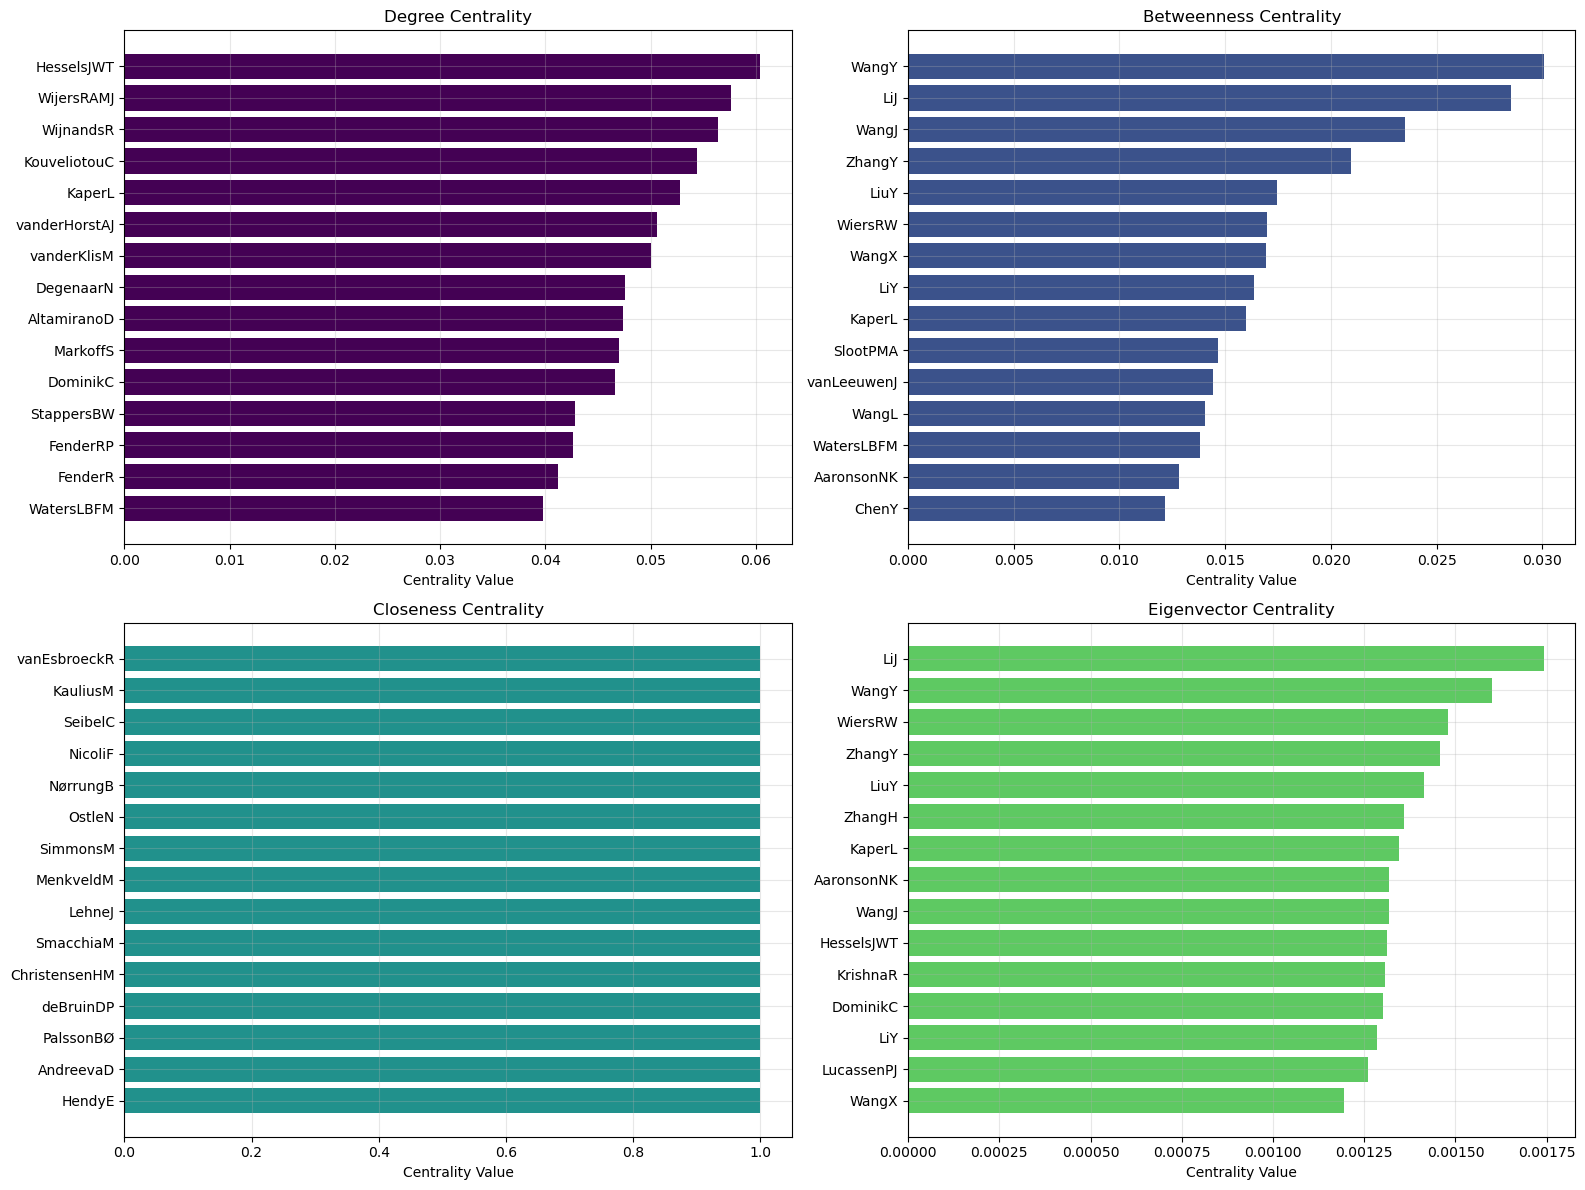

In [289]:
# Create a comparison plot of different centrality measures for top airports
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

centrality_names = ['degree', 'betweenness', 'closeness', 'pagerank']
centrality_titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

for i, (name, title) in enumerate(zip(centrality_names, centrality_titles)):
    # Get top 15 airports for this centrality measure
    sorted_airports = sorted(centralities[name].items(), key=lambda x: x[1], reverse=True)[:15]
    airports = [item[0] for item in sorted_airports]
    values = [item[1] for item in sorted_airports]
    
    # Create horizontal bar plot
    axes[i].barh(range(len(airports)), values, color=plt.cm.viridis(i/4))
    axes[i].set_yticks(range(len(airports)))
    axes[i].set_yticklabels(airports)
    axes[i].set_xlabel('Centrality Value')
    axes[i].set_title(title)
    axes[i].grid(True, alpha=0.3)
    
    # Invert y-axis to show highest values at top
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig('centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [295]:
def create_model_networks(real_G):
    """
    Create three model networks with similar size and average degree to the real network
    """
    # Get real network properties
    N_real = real_G.number_of_nodes()
    avg_degree_real = np.mean([d for n, d in real_G.degree()])
    m_real = int(avg_degree_real / 2)  # For BA model
    
    print(f"Real network: N={N_real}, <k>={avg_degree_real:.2f}")
    
    # Create model networks
    print("\nCreating model networks...")
    
    # 1. Erdős–Rényi model
    p = avg_degree_real / (N_real - 1)
    G_er = nx.erdos_renyi_graph(N_real, p, seed=42)
    
    # 2. Watts–Strogatz model
    k = int(avg_degree_real)  # Nearest neighbors (even number)
    if k % 2 != 0:
        k = k - 1  # Make even for WS model
    p_rewire = 0.1  # Rewiring probability
    G_ws = nx.watts_strogatz_graph(N_real, k, p_rewire, seed=42)
    
    # 3. Barabási–Albert model
    # BA model adds m edges per new node, so final average degree is ~2m
    m_ba = max(1, m_real)  # At least 1 edge per new node
    G_ba = nx.barabasi_albert_graph(N_real, m_ba, seed=42)
    
    return G_er, G_ws, G_ba, N_real, avg_degree_real

def calculate_network_statistics(G, name):
    """
    Calculate key network statistics for comparison
    """
    stats = {}
    
    # Basic properties
    stats['Network'] = name
    stats['N'] = G.number_of_nodes()
    stats['E'] = G.number_of_edges()
    
    # Degree statistics
    degrees = [d for n, d in G.degree()]
    stats['Avg Degree'] = np.mean(degrees)
    stats['Max Degree'] = np.max(degrees)
    stats['Degree Std'] = np.std(degrees)
    
    # Connected components
    components = list(nx.connected_components(G))
    stats['Number of Components'] = len(components)
    largest_cc = max(components, key=len)
    stats['LCC Size'] = len(largest_cc)
    stats['LCC Fraction'] = len(largest_cc) / G.number_of_nodes()
    
    # Density
    stats['Density'] = nx.density(G)
    
    # Clustering
    stats['Avg Clustering'] = nx.average_clustering(G)
    
    # Path length (on largest connected component)
    if len(largest_cc) > 1:
        G_lcc = G.subgraph(largest_cc)
        stats['Avg Path Length'] = nx.average_shortest_path_length(G_lcc)
    else:
        stats['Avg Path Length'] = 0
    
    return stats, degrees

def plot_degree_comparison(real_degrees, er_degrees, ws_degrees, ba_degrees, network_names):
    """
    Plot degree distribution comparison across all networks
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    all_degrees = [real_degrees, er_degrees, ws_degrees, ba_degrees]
    
    for i, (degrees, name) in enumerate(zip(all_degrees, network_names)):
        # Linear scale
        degree_counts = Counter(degrees)
        axes[i].bar(degree_counts.keys(), degree_counts.values(), alpha=0.7, color='skyblue')
        axes[i].set_xlabel('Degree')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{name} - Degree Distribution')
        axes[i].grid(True, alpha=0.3)
        
        # Set reasonable x-axis limits
        axes[i].set_xlim(0, min(max(degrees) * 1.1, 1000))
    
    plt.tight_layout()
    plt.savefig('degree_distributions_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Log-log plot for all networks
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'red', 'green', 'orange']
    
    for degrees, name, color in zip(all_degrees, network_names, colors):
        degree_counts = Counter(degrees)
        degrees_vals = list(degree_counts.keys())
        counts_vals = list(degree_counts.values())
        
        plt.loglog(degrees_vals, counts_vals, 'o', alpha=0.7, color=color, 
                  label=name, markersize=4)
    
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distributions - Log-Log Scale')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('degree_distributions_loglog.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_statistics_comparison(stats_df):
    """
    Create visual comparison of key network statistics
    """
    # Select key metrics for comparison
    metrics = ['Avg Degree', 'Avg Clustering', 'Avg Path Length', 'Density', 'LCC Fraction']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        if i < len(axes):
            bars = axes[i].bar(stats_df['Network'], stats_df[metric], 
                              color=['blue', 'red', 'green', 'orange'], alpha=0.7)
            axes[i].set_title(metric)
            axes[i].set_ylabel(metric)
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Remove empty subplot
    if len(metrics) < len(axes):
        fig.delaxes(axes[len(metrics)])
    
    plt.tight_layout()
    plt.savefig('network_statistics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:
# Main analysis
print("Starting network model comparison...")

# Create model networks
G_er, G_ws, G_ba, N_real, avg_degree_real = create_model_networks(G)

# Calculate statistics for all networks
networks = {
    'Real Co-authorship': G,
    'Erdős–Rényi': G_er,
    'Watts–Strogatz': G_ws,
    'Barabási–Albert': G_ba
}

all_stats = []
all_degrees = {}

print("\nCalculating network statistics...")
for name, graph in networks.items():
    stats, degrees = calculate_network_statistics(graph, name)
    all_stats.append(stats)
    all_degrees[name] = degrees
    print(f"\n{name}:")
    for key, value in stats.items():
        if key != 'Network':
            print(f"  {key}: {value:.4f}")



Starting network model comparison...
Real network: N=88512, <k>=17.42

Creating model networks...


In [ ]:
# Create comparison DataFrame
stats_df = pd.DataFrame(all_stats)
print(f"\n{'='*60}")
print("NETWORK STATISTICS COMPARISON")
print(f"{'='*60}")
print(stats_df.round(4).to_string(index=False))

# Save comparison table
stats_df.to_csv('network_model_comparison.csv', index=False)
print("\nComparison table saved to 'network_model_comparison.csv'")



In [ ]:
# Create visualizations
network_names = list(networks.keys())
real_degrees = all_degrees['Real Co-authorship']
er_degrees = all_degrees['Erdős–Rényi']
ws_degrees = all_degrees['Watts–Strogatz']
ba_degrees = all_degrees['Barabási–Albert']

# Plot degree distributions
plot_degree_comparison(real_degrees, er_degrees, ws_degrees, ba_degrees, network_names)

# Plot statistics comparison
plot_statistics_comparison(stats_df)

# Additional analysis: Clustering vs Degree
print(f"\n{'='*60}")
print("ADDITIONAL ANALYSIS")
print(f"{'='*60}")



In [ ]:
# Calculate degree assortativity
for name, graph in networks.items():
    assortativity = nx.degree_assortativity_coefficient(graph)
    print(f"{name} - Degree assortativity: {assortativity:.4f}")

# Analyze degree distribution properties
print("\nDegree Distribution Properties:")
for name, degrees in all_degrees.items():
    degree_array = np.array(degrees)
    print(f"\n{name}:")
    print(f"  Mean degree: {np.mean(degree_array):.2f}")
    print(f"  Median degree: {np.median(degree_array):.2f}")
    print(f"  Degree variance: {np.var(degree_array):.2f}")
    print(f"  Max degree: {np.max(degree_array)}")
    print(f"  Min degree: {np.min(degree_array)}")